## Import required libraries and packages

In [1]:
import evaluate
import pathlib
import yaml
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 

In [2]:
OUTPUT_PATH = "../benchmark_dir"

## Helper functions

In [3]:
def create_path_generator(file_path):
    return pathlib.Path(f"{file_path}").glob("**/*")

In [4]:
def read_yaml_file(file_path, content_type):
    with open(file_path) as file:
        instructions = yaml.load(file, Loader=yaml.Loader)
    return yaml.dump(instructions[content_type])

In [5]:
def remove_quotes_and_new_lines(instructions: str) -> list:
    instructions = instructions.replace("'", "").replace('"', "").split("- Step")
    instructions = [
        instruction.strip().replace("\n", "")
        for instruction in instructions
        if instruction != ""
    ]
    return instructions

In [6]:
path_generator = create_path_generator(
    file_path=f"{OUTPUT_PATH}/intermediate_responses/"
)
correct_response_file_paths = [str(path) for path in path_generator]
correct_response_file_paths = correct_response_file_paths[4:111]

## Load evaluation metrics

In [7]:
bleu = evaluate.load("bleu")
google_bleu = evaluate.load("google_bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

Using the latest cached version of the module from C:\Users\Amilas_Windows_VM\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--bleu\9e0985c1200e367cce45605ce0ecb5ede079894e0f24f54613fca08eeb8aff76 (last modified on Thu Aug 29 09:22:20 2024) since it couldn't be found locally at evaluate-metric--bleu, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\Amilas_Windows_VM\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--google_bleu\6fc70b7be0088120a372dfdd5d320b39b8bb3630cb8029b193941d9376e86bb0 (last modified on Thu Aug 29 09:31:05 2024) since it couldn't be found locally at evaluate-metric--google_bleu, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\Amilas_Windows_VM\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--rouge\b01e0accf3bd6dd24839b769a5fda24e14995071570870922c71970b3a6ed886 (last modified on Thu Aug 29 09:34:34 2024) since 

In [ ]:
EXAMPLES_COUNT = 107
llm_metrics = {}
llm_models = [
    "gemma2-9b-it",
    "llama-3.3-70b-versatile",
    "mixtral-8x7b-32768",
    "gpt-4o",
    "gpt-4o-mini",
]
for model_name in tqdm(llm_models):
    bleu_scores = []
    gleu_scores = []
    rouge_scores = []
    meteor_scores = []

    if model_name == "mixtral-8x7b-32768":
        few_shot_count = 1  # Used a smaller few shot due to smaller context window
    else:
        few_shot_count = 4

    path_generator = create_path_generator(
        file_path=f"{OUTPUT_PATH}/{model_name}/model_responses/{few_shot_count}_shot/"
    )
    llm_responses_file_paths = [str(path) for path in path_generator]
    for test_index in tqdm(range(EXAMPLES_COUNT)):
        correct_file_path = correct_response_file_paths[test_index]
        predicted_file_path = llm_responses_file_paths[test_index]

        # Correct instructions
        correct_instructions = read_yaml_file(
            file_path=correct_file_path, content_type="intermediate response"
        )
        correct_instructions = remove_quotes_and_new_lines(correct_instructions)

        # predicted instructions
        predicted_instructions = read_yaml_file(
            file_path=predicted_file_path, content_type=f"{model_name}_response"
        )
        predicted_instructions = remove_quotes_and_new_lines(predicted_instructions)
        predicted_instructions = ["\n".join(predicted_instructions)]
        correct_instructions = ["\n".join(correct_instructions)]

        if len(predicted_instructions) != len(correct_instructions):
            print(f"Predicted file: {predicted_file_path}")
            print(f"Correct file: {correct_file_path}")
            print(f"Predicted: {predicted_instructions}")
            print(f"Correct: {correct_instructions}")

        # BLEU
        bleu_results = bleu.compute(
            predictions=predicted_instructions, references=correct_instructions
        )
        bleu_scores.append(bleu_results["bleu"])

        # GLEU
        google_bleu_results = google_bleu.compute(
            predictions=predicted_instructions, references=correct_instructions
        )
        gleu_scores.append(google_bleu_results["google_bleu"])

        # Rouge-L
        rouge_results = rouge.compute(
            predictions=predicted_instructions, references=correct_instructions
        )
        rouge_scores.append(rouge_results["rougeL"])

        # METEOR
        meteor_results = meteor.compute(
            predictions=predicted_instructions, references=correct_instructions
        )
        meteor_scores.append(meteor_results["meteor"])

        Z_90_CONFIDENCE_INTERVAL = 1.645
        metrics = {
            "mean_bleu": np.mean(bleu_scores),
            "std_bleu": np.std(bleu_scores),
            "ci_bleu": (Z_90_CONFIDENCE_INTERVAL * np.std(bleu_scores))
            / np.sqrt(EXAMPLES_COUNT),
            "mean_gleu": np.mean(gleu_scores),
            "std_gleu": np.std(gleu_scores),
            "ci_gleu": (Z_90_CONFIDENCE_INTERVAL * np.std(gleu_scores))
            / np.sqrt(EXAMPLES_COUNT),
            "mean_rouge": np.mean(rouge_scores),
            "std_rouge": np.std(rouge_scores),
            "ci_rouge": (Z_90_CONFIDENCE_INTERVAL * np.std(rouge_scores))
            / np.sqrt(EXAMPLES_COUNT),
            "mean_meteor": np.mean(meteor_scores),
            "std_meteor": np.std(meteor_scores),
            "ci_meteor": (Z_90_CONFIDENCE_INTERVAL * np.std(meteor_scores))
            / np.sqrt(EXAMPLES_COUNT),
        }
        llm_metrics[model_name] = metrics

100%|██████████| 5/5 [03:04<00:00, 36.88s/it]


In [9]:
llm_metrics

{'gemma2-9b-it': {'mean_bleu': 0.04193970795652704,
  'std_bleu': 0.09274545856096299,
  'ci_bleu': 0.014749138922893567,
  'mean_gleu': 0.060237363866292325,
  'std_gleu': 0.10728720331639635,
  'ci_gleu': 0.0170616857247207,
  'mean_rouge': 0.15512948294828435,
  'std_rouge': 0.22601379126559948,
  'ci_rouge': 0.03594255565273884,
  'mean_meteor': 0.08817886924635428,
  'std_meteor': 0.1701530104677003,
  'ci_meteor': 0.027059118888145564},
 'llama-3.3-70b-versatile': {'mean_bleu': 0.2572799217145534,
  'std_bleu': 0.18075252993712854,
  'ci_bleu': 0.028744740886205464,
  'mean_gleu': 0.32240139065514734,
  'std_gleu': 0.1510416553911116,
  'ci_gleu': 0.02401987539953774,
  'mean_rouge': 0.5243811219100625,
  'std_rouge': 0.1683307561741686,
  'ci_rouge': 0.02676932915455476,
  'mean_meteor': 0.4644074582250267,
  'std_meteor': 0.18176061578522404,
  'ci_meteor': 0.028905054916137082},
 'mixtral-8x7b-32768': {'mean_bleu': 0.08021786121521587,
  'std_bleu': 0.09244800445275593,
  'ci_

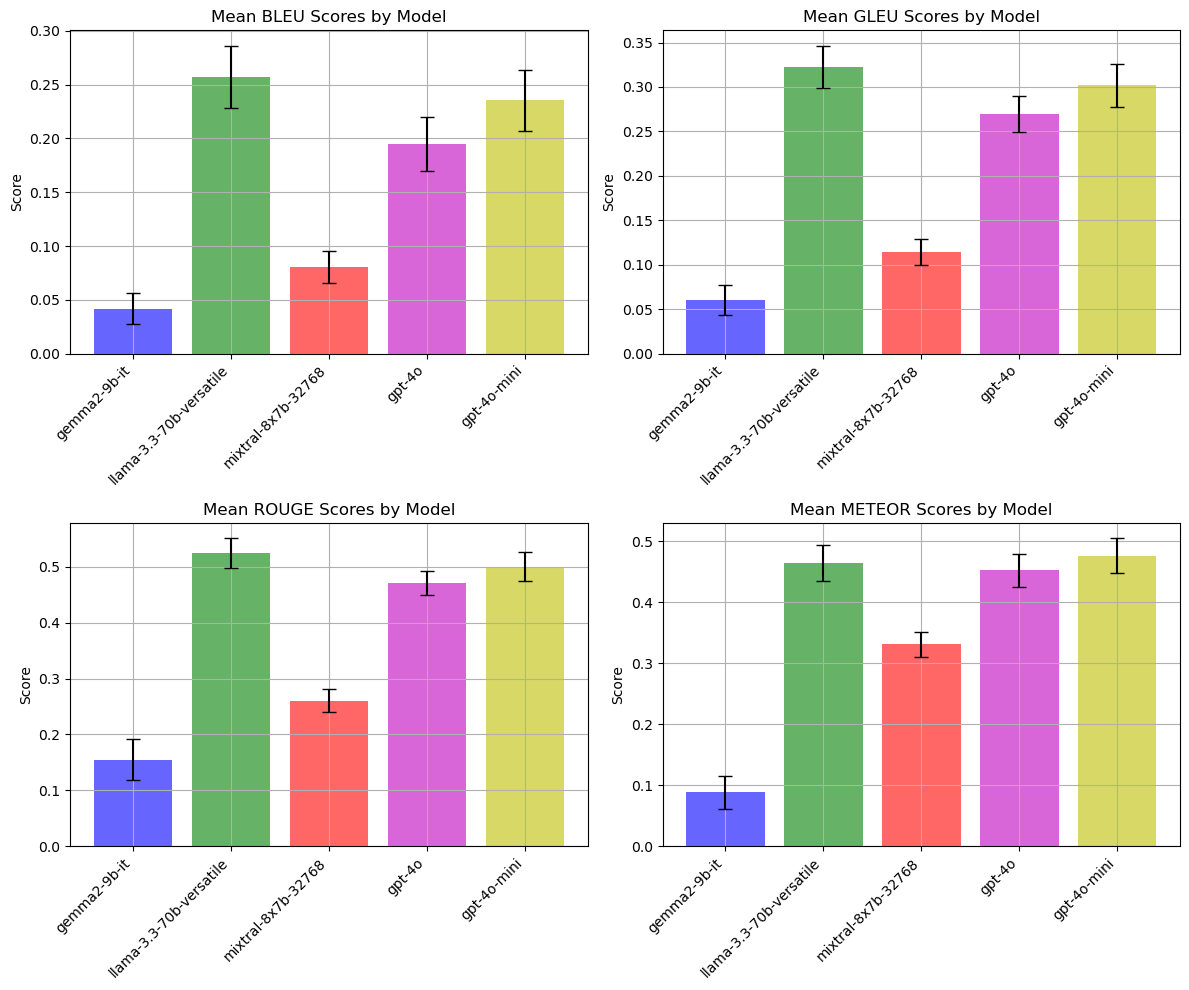

In [38]:
# Metrics to plot
metrics = ["bleu", "gleu", "rouge", "meteor"]
colors = ["b", "g", "r", "m", "y"]
models = list(llm_metrics.keys())

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # Extract values for each model
    means = [llm_metrics[model][f"mean_{metric}"] for model in models]
    stds = [llm_metrics[model][f"std_{metric}"] for model in models]
    cis = [llm_metrics[model][f"ci_{metric}"] for model in models]
    
    x = np.arange(len(models))  # X-axis positions
    lower_bounds = np.array(means) - np.array(cis)
    upper_bounds = np.array(means) + np.array(cis)
    
    # Plot mean values
    ax.bar(x, means, yerr=cis, color=colors, alpha=0.6, capsize=5)
    
    
    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha="right")
    ax.set_title(f"Mean {metric.upper()} Scores by Model")
    ax.set_ylabel("Score")
    ax.grid()
    # ax.legend()

plt.tight_layout()
plt.show()